<a href="https://colab.research.google.com/github/shubham151/ViT-Adversarial-Enhancement/blob/main/Image_Classification_using_ViT_and_Enhancing_Adversarial_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from timm import create_model
import os
import matplotlib.pyplot as plt
import numpy as np
import gc
from torch.utils.data import Subset

In [ ]:
# Define hyperparameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 10
checkpoint_path = '/content/drive/MyDrive/PatternProject/vit_checkpoint.pth'

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13414144.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [ ]:
# Create ViT model with pretrained weights
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")


In [ ]:
# train_losses = []
# test_accuracies = []

train_losses = [0.1877, 0.1049, 0.0802, 0.0633, 0.0605, 0.0530, 0.0535, 0.0416, 0.0486, 0.0390]
test_accuracies = [96.01, 94.51, 95.77, 94.24, 93.93, 94.11, 94.83, 93.85, 94.88, 94.18]
adversarial_accuracies = []

In [ ]:
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Test Accuracy: {accuracy:.2f}%")

Checkpoint saved at epoch 1
Epoch [1/10] - Train Loss: 0.1877 - Test Accuracy: 96.01%
Checkpoint saved at epoch 2
Epoch [2/10] - Train Loss: 0.1049 - Test Accuracy: 94.51%
Checkpoint saved at epoch 3
Epoch [3/10] - Train Loss: 0.0802 - Test Accuracy: 95.77%
Checkpoint saved at epoch 4
Epoch [4/10] - Train Loss: 0.0633 - Test Accuracy: 94.24%
Checkpoint saved at epoch 5
Epoch [5/10] - Train Loss: 0.0605 - Test Accuracy: 93.93%
Checkpoint saved at epoch 6
Epoch [6/10] - Train Loss: 0.0530 - Test Accuracy: 94.11%
Checkpoint saved at epoch 7
Epoch [7/10] - Train Loss: 0.0535 - Test Accuracy: 94.83%
Checkpoint saved at epoch 8
Epoch [8/10] - Train Loss: 0.0416 - Test Accuracy: 93.85%
Checkpoint saved at epoch 9
Epoch [9/10] - Train Loss: 0.0486 - Test Accuracy: 94.88%
Checkpoint saved at epoch 10
Epoch [10/10] - Train Loss: 0.0390 - Test Accuracy: 94.18%


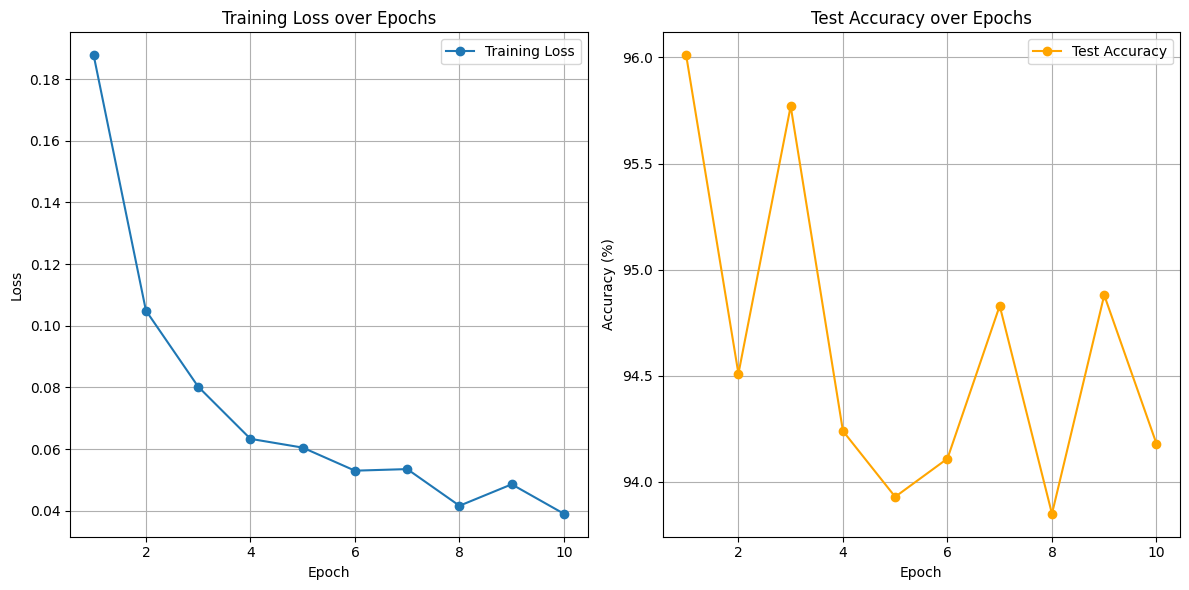

In [ ]:
n_epoch = list(range(1, 11))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_epoch, train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(n_epoch, test_accuracies, marker='o', color='orange', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
correctly_classified_images = []
correctly_classified_labels = []
correctly_classified_preds = []

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect some correctly classified images
        for i in range(len(labels)):
            if predicted[i] == labels[i]:
                correctly_classified_images.append(images[i].cpu())
                correctly_classified_labels.append(labels[i].cpu())
                correctly_classified_preds.append(predicted[i].cpu())
                if len(correctly_classified_images) >= 5:  # Display 5 correct images
                    break
        if len(correctly_classified_images) >= 5:
            break

In [ ]:
# Display some correctly classified images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
class_names = train_dataset.classes

Displaying some correctly classified images...


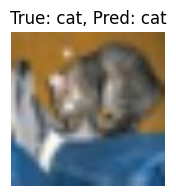

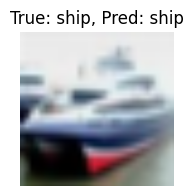

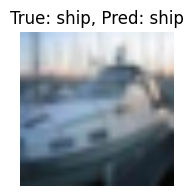

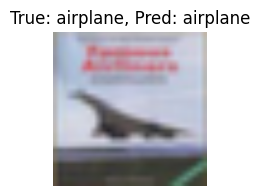

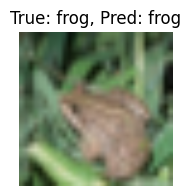

In [ ]:
print("Displaying some correctly classified images...")
for i in range(len(correctly_classified_images)):
    plt.figure(figsize=(2, 2))
    imshow(correctly_classified_images[i])
    plt.title(f"True: {class_names[correctly_classified_labels[i]]}, Pred: {class_names[correctly_classified_preds[i]]}")
    plt.axis('off')
    plt.show()

In [ ]:
trained_model_path = '/content/drive/MyDrive/PatternProject/cifar10_vit.pth'

In [ ]:
# Save trained model

# torch.save(model.state_dict(), trained_model_path)
# print("ViT model saved successfully!")

In [ ]:
# Load trained model
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model.load_state_dict(torch.load(trained_model_path))
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# PGD attack function
def projected_gradient_descent(model, images, labels, criterion, eps=0.03, alpha=0.01, num_iter=40):
    adv_images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = adv_images.grad
        adv_images = adv_images + alpha * grad.sign()
        perturbation = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + perturbation, min=0, max=1).detach_().requires_grad_(True)
    return adv_images

In [ ]:
# FGSM attack function
def fgsm_attack(model, images, labels, criterion, eps=0.03):
    images = images.clone().detach().requires_grad_(True).to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad = images.grad
    adv_images = images + eps * grad.sign()
    adv_images = torch.clamp(adv_images, min=0, max=1)
    return adv_images

In [ ]:
fgsm_accuracies = []
fgsm_losses = []

In [ ]:
def evaluate_fgsm_attack(model, dataloader, criterion, device, eps):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, criterion, eps)
        with torch.no_grad():
            outputs = model(adv_images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Detach the gradients to free GPU memory
        adv_images.detach_()
        del images, labels, outputs, predicted
        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            del images, labels, outputs, predicted
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")

Resuming training from epoch 8


In [ ]:
subset_size = 10000


# Load CIFAR-10 dataset without downloading
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=False)

# Sample a subset of the dataset
subset_indices = list(range(subset_size))
train_subset = Subset(train_dataset, subset_indices)
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize lists to store accuracy and loss for each epoch
clean_accuracies = []
clean_losses = []
fgsm_accuracies = []
fgsm_losses = []
train_losses = []

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0


    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = fgsm_attack(model, images, labels, criterion, eps=0.03)


        # Concatenate clean and adversarial examples
        combined_images = torch.cat((images, adv_images))
        combined_labels = torch.cat((labels, labels))

        # del images, labels
        # torch.cuda.empty_cache()

        optimizer.zero_grad()
        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # del outputs, loss
        # torch.cuda.empty_cache()
        # Clear cache to prevent memory issues


    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Evaluate model on clean images
    clean_accuracy, clean_loss = evaluate(model, test_loader, criterion, device)
    clean_accuracies.append(clean_accuracy)
    clean_losses.append(clean_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Test Accuracy: {clean_accuracy:.2f}%")

    # Evaluate model on adversarial images
    fgsm_accuracy, fgsm_loss = evaluate_fgsm_attack(model, test_loader, criterion, device, eps=0.03)
    fgsm_accuracies.append(fgsm_accuracy)
    fgsm_losses.append(fgsm_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - FGSM Test Loss: {fgsm_loss:.4f} - FGSM Test Accuracy: {fgsm_accuracy:.2f}%")


Checkpoint saved at epoch 1
Epoch [1/10] - Train Loss: 0.1193 - Test Accuracy: 95.23%
Epoch [1/10] - FGSM Test Loss: 0.8143 - FGSM Test Accuracy: 71.80%
Checkpoint saved at epoch 2
Epoch [2/10] - Train Loss: 0.0544 - Test Accuracy: 94.65%
Epoch [2/10] - FGSM Test Loss: 0.8884 - FGSM Test Accuracy: 71.66%
Checkpoint saved at epoch 3
Epoch [3/10] - Train Loss: 0.0355 - Test Accuracy: 94.14%
Epoch [3/10] - FGSM Test Loss: 0.9005 - FGSM Test Accuracy: 71.42%
Checkpoint saved at epoch 4
Epoch [4/10] - Train Loss: 0.0270 - Test Accuracy: 94.12%
Epoch [4/10] - FGSM Test Loss: 0.9864 - FGSM Test Accuracy: 72.18%
Checkpoint saved at epoch 5
Epoch [5/10] - Train Loss: 0.0202 - Test Accuracy: 93.99%
Epoch [5/10] - FGSM Test Loss: 1.1168 - FGSM Test Accuracy: 69.39%
Checkpoint saved at epoch 6
Epoch [6/10] - Train Loss: 0.0186 - Test Accuracy: 92.55%
Epoch [6/10] - FGSM Test Loss: 1.2473 - FGSM Test Accuracy: 71.15%
Checkpoint saved at epoch 7
Epoch [7/10] - Train Loss: 0.0139 - Test Accuracy: 92.

In [ ]:
trained_model_path = '/content/drive/MyDrive/PatternProject/cifar10_vit_fgsm.pth'
torch.save(model.state_dict(), trained_model_path)
print("ViT model saved successfully!")

ViT model saved successfully!


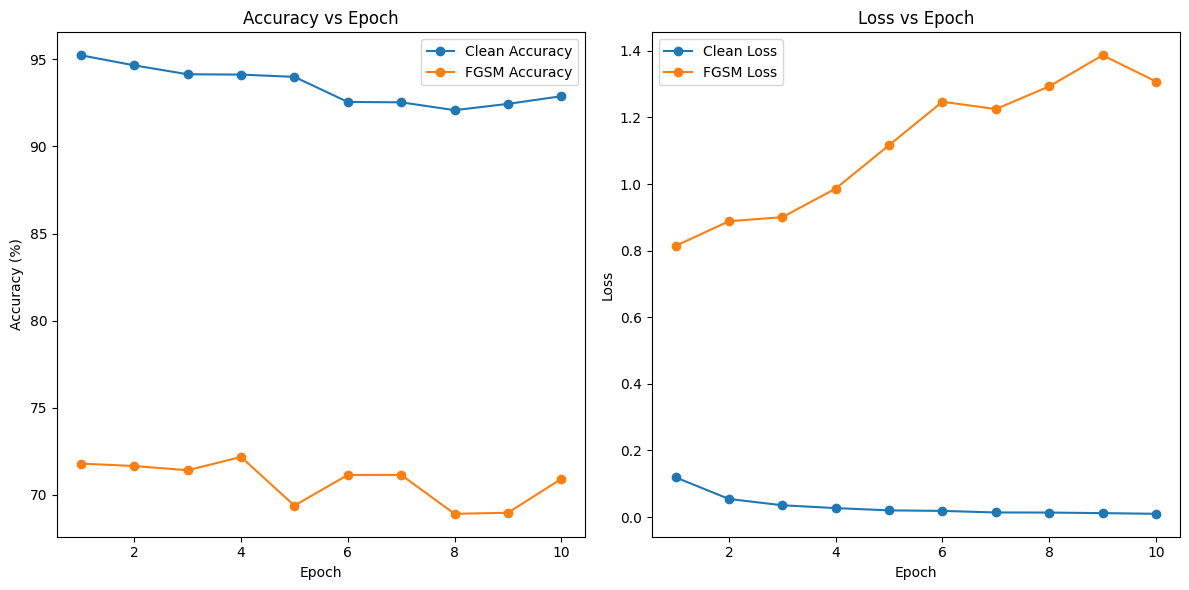

In [ ]:
# Plot Clean and FGSM Accuracies vs Epoch
n_epoch = list(range(1, 11))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_epoch, clean_accuracies, label='Clean Accuracy', marker='o')
plt.plot(n_epoch, fgsm_accuracies, label='FGSM Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

# Plot Clean and FGSM Losses vs Epoch
plt.subplot(1, 2, 2)
plt.plot(n_epoch, clean_losses, label='Clean Loss', marker='o')
plt.plot(n_epoch, fgsm_losses, label='FGSM Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pgd_checkpoint_path = '/content/drive/MyDrive/PatternProject/vit_checkpoint_pgd.pth'

In [ ]:
start_epoch = 0
if os.path.exists(pgd_checkpoint_path):
    checkpoint = torch.load(pgd_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")

pgd_losses = []
pgd_accuracies = []

Resuming training from epoch 10


In [ ]:
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0.0


    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = projected_gradient_descent(model, images, labels, criterion)

        # Concatenate clean and adversarial examples
        combined_images = torch.cat((images, adv_images))
        combined_labels = torch.cat((labels, labels))

        optimizer.zero_grad()
        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    pgd_losses.append(avg_train_loss)
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, pgd_checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    pgd_accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] - PGD Test Loss: {avg_train_loss:.4f} - PGD Test Accuracy: {accuracy:.2f}%")

Checkpoint saved at epoch 1
Epoch [1/10] - PGD Test Loss: 0.9543 - PGD Test Accuracy: 68.33%
Checkpoint saved at epoch 2
Epoch [2/10] - PGD Test Loss: 0.9284 - PGD Test Accuracy: 69.21%
Checkpoint saved at epoch 3
Epoch [3/10] - PGD Test Loss: 0.9005 - PGD Test Accuracy: 69.72%
Checkpoint saved at epoch 4
Epoch [4/10] - PGD Test Loss: 0.9464 - PGD Test Accuracy: 70.34%
Checkpoint saved at epoch 5
Epoch [5/10] - PGD Test Loss: 0.9168 - PGD Test Accuracy: 71.01%
Checkpoint saved at epoch 6
Epoch [6/10] - PGD Test Loss: 0.8973 - PGD Test Accuracy: 71.32%
Checkpoint saved at epoch 7
Epoch [7/10] - PGD Test Loss: 0.8950 - PGD Test Accuracy: 70.55%
Checkpoint saved at epoch 8
Epoch [8/10] - PGD Test Loss: 0.9034 - PGD Test Accuracy: 70.10%
Checkpoint saved at epoch 9
Epoch [9/10] - PGD Test Loss: 0.9867 - PGD Test Accuracy: 71.23%
Checkpoint saved at epoch 10
Epoch [10/10] - PGD Test Loss: 0.9432 - PGD Test Accuracy: 71.74%


In [ ]:
# Save adversarially trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/PatternProject/cifar10_vit_pgd.pth')
print("PGD trained ViT model saved successfully!")

PGD trained ViT model saved successfully!


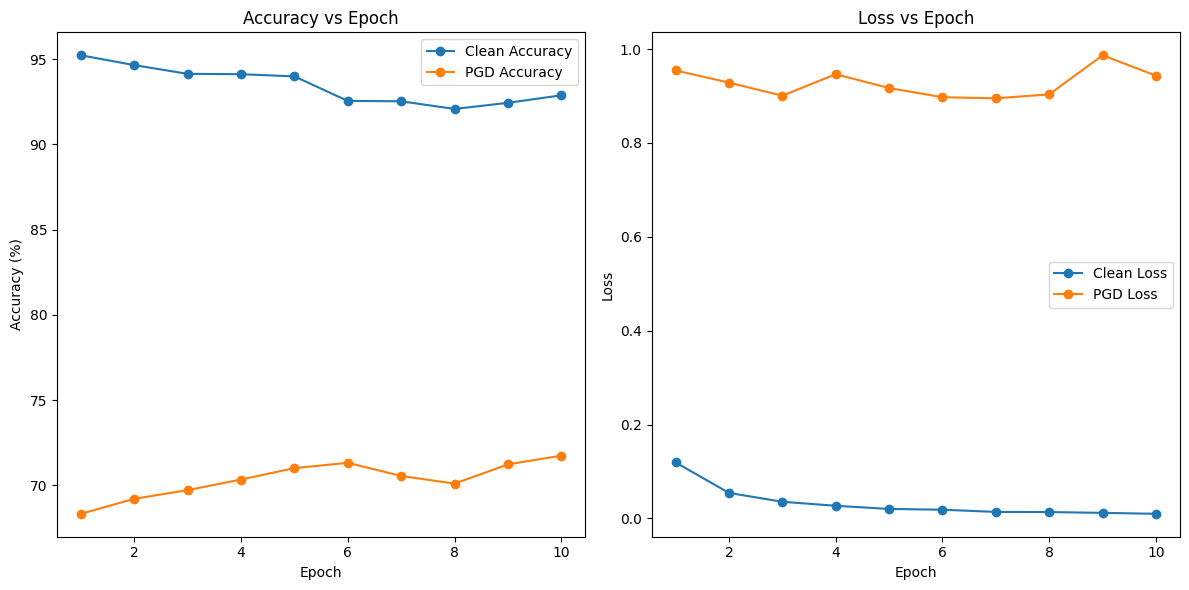

In [ ]:
n_epoch = list(range(1, 11))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_epoch, clean_accuracies, label='Clean Accuracy', marker='o')
plt.plot(n_epoch, pgd_accuracies, label='PGD Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

# Plot Clean and FGSM Losses vs Epoch
plt.subplot(1, 2, 2)
plt.plot(n_epoch, clean_losses, label='Clean Loss', marker='o')
plt.plot(n_epoch, pgd_losses, label='PGD Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


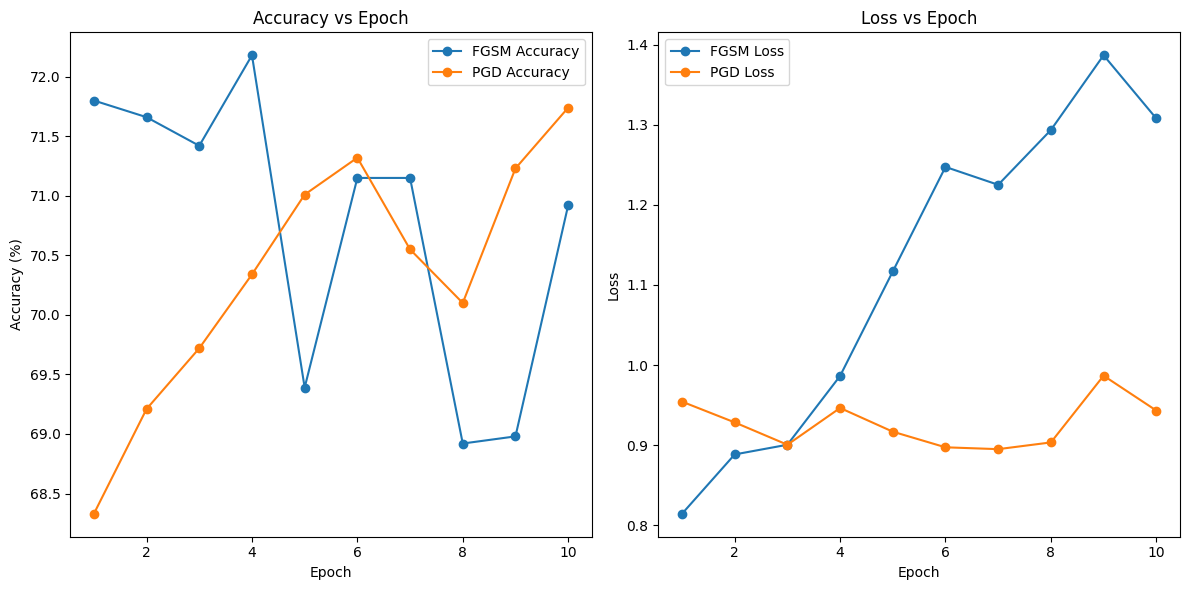

In [ ]:
n_epoch = list(range(1, 11))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_epoch, fgsm_accuracies, label='FGSM Accuracy', marker='o')
plt.plot(n_epoch, pgd_accuracies, label='PGD Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

# Plot Clean and FGSM Losses vs Epoch
plt.subplot(1, 2, 2)
plt.plot(n_epoch, fgsm_losses, label='FGSM Loss', marker='o')
plt.plot(n_epoch, pgd_losses, label='PGD Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()